In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy.spatial as sc

In [3]:
image_folder_path = "./fruit-inspection-images"
images_second_task_path = os.path.join(image_folder_path, "second-task")
images_second_task = os.listdir(images_second_task_path)

ir_images = []
color_images = []

for img in images_second_task:
    if img[:2] == "C0":
        ir_images.append(img)
    else:
        color_images.append(img)

def load_image(image_number, ir = True):
    ir_image_path = os.path.join(images_second_task_path, ir_images[image_number])
    color_image_path = os.path.join(images_second_task_path, color_images[image_number])
    image = cv2.imread(ir_image_path if ir else color_image_path, cv2.IMREAD_COLOR)
    return image

def load_image_grey(image_number, ir = True):
    ir_image_path = os.path.join(images_second_task_path, ir_images[image_number])
    color_image_path = os.path.join(images_second_task_path, color_images[image_number])
    image = cv2.imread(ir_image_path if ir else color_image_path, cv2.IMREAD_GRAYSCALE)
    return image



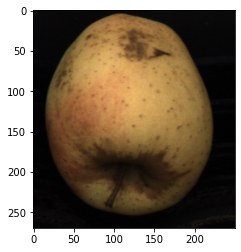

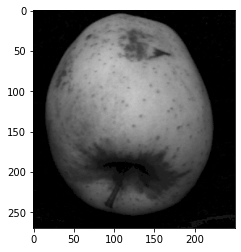

In [4]:
def show_image(image, grey = False):
    if not grey:
        plt.imshow(image)
    else:
        plt.imshow(image, cmap="gray", vmin=0, vmax=255)
    plt.show()

image = load_image(0, False)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
show_image(image)


image_grey = load_image_grey(0, False)
show_image(image_grey, True)

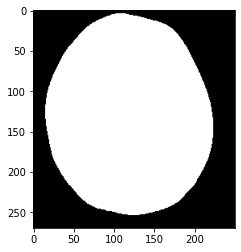

In [16]:
ret, th = cv2.threshold(image_grey, 25, 255, cv2.THRESH_BINARY) #Todo, finn bedre threshold

#Floodfill and invert
th_copy = th.copy()
h, w = th.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)
cv2.floodFill(th_copy, mask, (0,0), 255)
th_inv = cv2.bitwise_not(th_copy)
im_out = th | th_inv

smooth_image = cv2.medianBlur(im_out, 3)
#smooth_image = cv2.GaussianBlur(im_out,(3,3),0)
show_image(smooth_image, True)

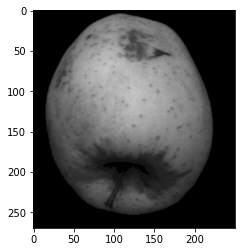

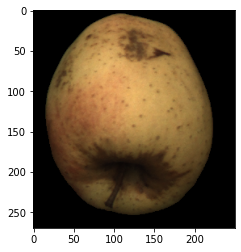

In [18]:
#Get the fruit from the mask
img_fuit = smooth_image & image_grey
show_image(img_fuit, True)


img_fruit_color = image.copy()
for i in range(3):
    img_fruit_color[:,:,i] =  smooth_image & image[:, :, i]

show_image(img_fruit_color)

134
0


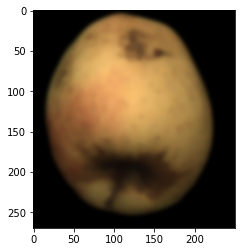

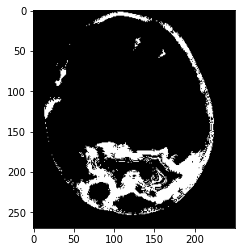

In [117]:
#Try out different color spaces here
img_fruit_color = cv2.medianBlur(img_fruit_color,3)
img_fruit_color_LAB = cv2.cvtColor(img_fruit_color, cv2.COLOR_RGB2LAB)


print(np.max(img_fruit_color_LAB[:][:][2]))
print(np.min(img_fruit_color_LAB[:][:][2]))

img_fruit_color_AB = img_fruit_color_LAB[:, :, 1:3]
img_fruit_color_AB = img_fruit_color_AB.reshape(img_fruit_color_AB.shape[0] * img_fruit_color_AB.shape[1], 2)
cov, mean = cv2.calcCovarMatrix(img_fruit_color_AB, None, cv2.COVAR_NORMAL | cv2.COVAR_ROWS | cv2.COVAR_SCALE)
cov_inv = cv2.invert(cov, cv2.DECOMP_SVD)

russet = np.zeros((img_fruit_color_LAB.shape[0], img_fruit_color_LAB.shape[1]), dtype="float64")
mask = np.array(smooth_image,dtype=bool)

#mean1 = np.mean(img_fruit_color_LAB[:,:,1], where = mask)
#mean2 = np.mean(img_fruit_color_LAB[:,:,2], where = mask)
#mean[0][0] = mean1
#mean[0][1] = mean2

#128 svart

for i in range(img_fruit_color_LAB.shape[0]):
        for j in range(img_fruit_color_LAB.shape[1]):
                #if img_fruit_color_LAB[i][j][1] != 128 and img_fruit_color_LAB[i][j][2] != 128 : #is a fruit pixel

                        pixel = np.array(img_fruit_color_LAB[i][j])[1:3].reshape(1, 2)

                        distance = sc.distance.cdist(pixel, mean, 'mahalanobis', VI=cov_inv[1])
                        
                        if distance < 0.8:
                                russet[i][j] = 255
show_image(img_fruit_color)
show_image(russet, True)


[1.19784018e+04 2.17707948e+01 3.56203955e+00]
0.21098740428139767
37.25800059318929


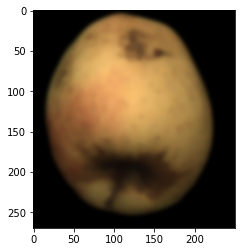

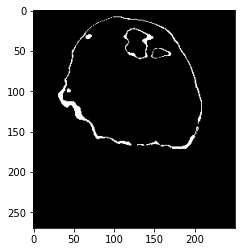

In [137]:
img_fruit_color = cv2.medianBlur(img_fruit_color, 3)

rgb_channels = cv2.split(img_fruit_color)
R = rgb_channels[0]
G = rgb_channels[1]
B = rgb_channels[2]

covDataRGB = [R.flatten(), G.flatten(), B.flatten()]
covMatrixRGB = np.cov(covDataRGB, bias=True)
mask = np.array(smooth_image,dtype=bool)

mean1 = np.mean(R, where = mask)
mean2 = np.mean(G, where = mask)
mean3 = np.mean(B, where = mask)
mean = np.array([mean1,mean2,mean3])

def get_pixel_value(im, i, j):
        pixel = np.array( [ im[i,j,0],   im[i,j,1], im[i,j,2] ]) 
        return pixel

def mahalanobis_distance(rgb_image, rgb_mean_vector, covariance_matrix):
    rgb_channels = cv2.split(rgb_image)
    R, G, B = rgb_channels[0], rgb_channels[1], rgb_channels[2]
    R_mean, G_mean, B_mean = rgb_mean_vector[0], rgb_mean_vector[1], rgb_mean_vector[2]
    distance = (((R - R_mean)**2/covariance_matrix[0,0]) + ((G - G_mean)**2/covariance_matrix[1,1]) + ((B - B_mean)**2/covariance_matrix[2,2]))
    return np.sqrt(distance)

def mahalanobis_distance_general(rgb_image, rgb_mean_vector, covariance_matrix):
        eigenvalues = np.linalg.eig(covariance_matrix)
        print(eigenvalues[0])

        R, G, B = rgb_channels[0], rgb_channels[1], rgb_channels[2]

        R_mean, G_mean, B_mean = rgb_mean_vector[0], rgb_mean_vector[1], rgb_mean_vector[2]
        distance = (((R - R_mean)**2/eigenvalues[0][0]) + ((G - G_mean)**2/eigenvalues[0][1]) + ((B - B_mean)**2/eigenvalues[0][2]))
        return np.sqrt(distance)



dist = mahalanobis_distance(img_fruit_color, mean, covMatrixRGB)
dist = mahalanobis_distance_general(img_fruit_color, mean, covMatrixRGB)


print(np.min(dist))
print(np.max(dist))

russet = np.zeros((img_fruit_color_LAB.shape[0], img_fruit_color_LAB.shape[1]), dtype="float64")


for i in range(dist.shape[0]):
        for j in range(dist.shape[1]):
                if dist[i][j] < 1.5:
                        russet[i][j] = 255

show_image(img_fruit_color)
show_image(russet, True)
            
